In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import subprocess
import torch
import torchvision

In [2]:
train_data_path=os.getcwd()+'/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
    print("Loading module failed: Could not locate data at %s."%train_data_path)

In [3]:
overwrite=False
!mkdir -p ./src
src_directory=os.getcwd()+'/src'
src_file=src_directory+'/mnist.py'
if(overwrite): 
    subprocess.call(['wget','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/mnist.py','-O',str(src_file)])
else:
    subprocess.call(['wget','-nc','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/mnist.py','-O',str(src_file)])
sys.path.append(src_directory)
import mnist
%matplotlib inline

Training on device  cpu


In [38]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 114.681416 	 train accuracy: 0.996500 	 valid accuracy: 0.986750 


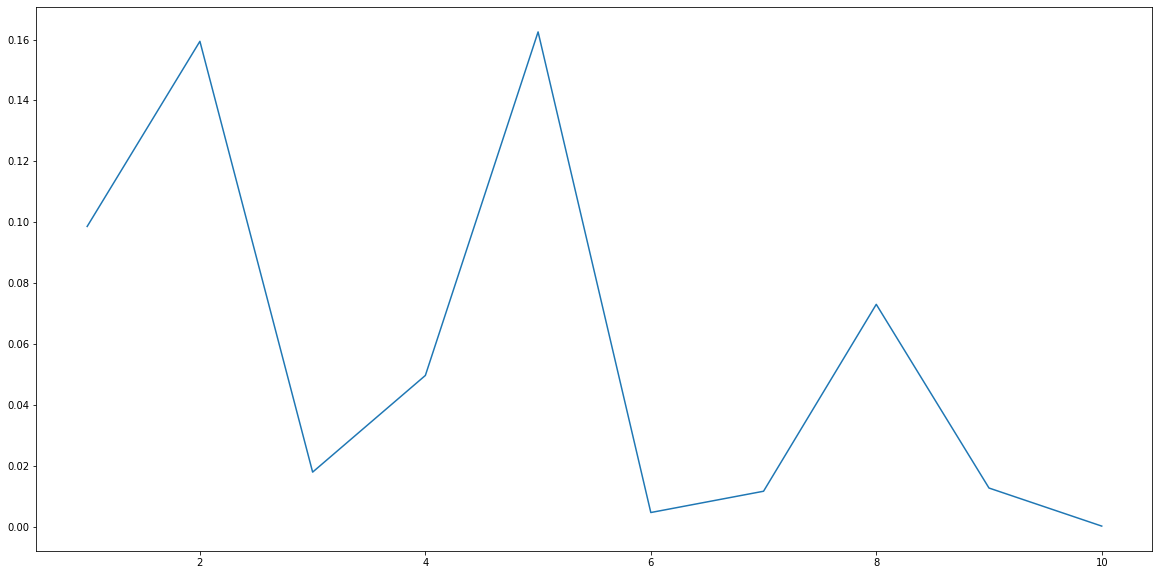

In [5]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 109.945725 	 train accuracy: 0.999875 	 valid accuracy: 0.989250 


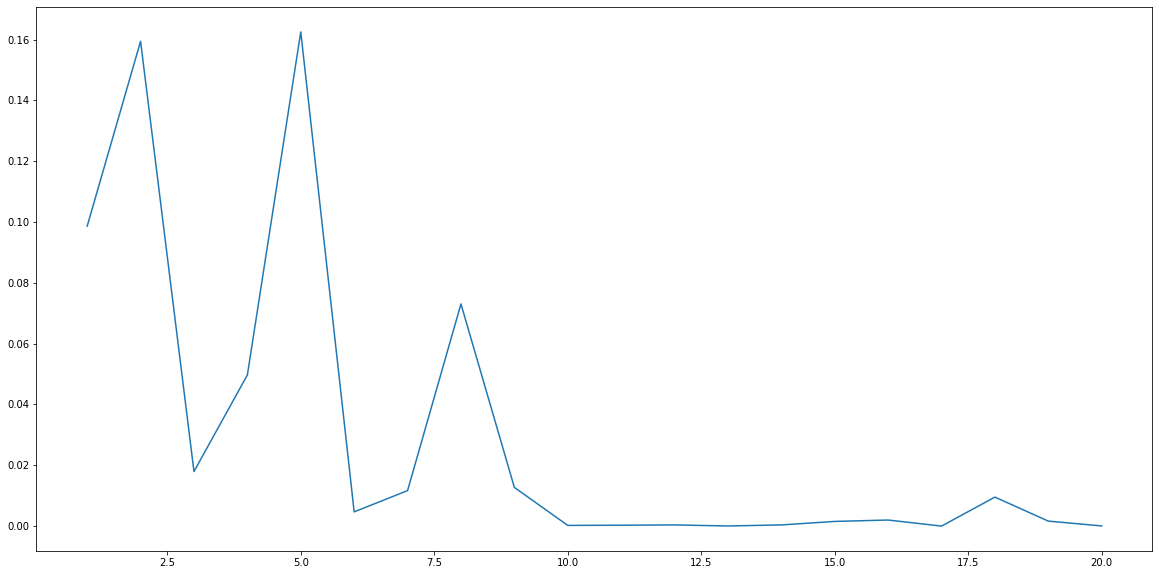

In [6]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 110.900966 	 train accuracy: 1.000000 	 valid accuracy: 0.991000 


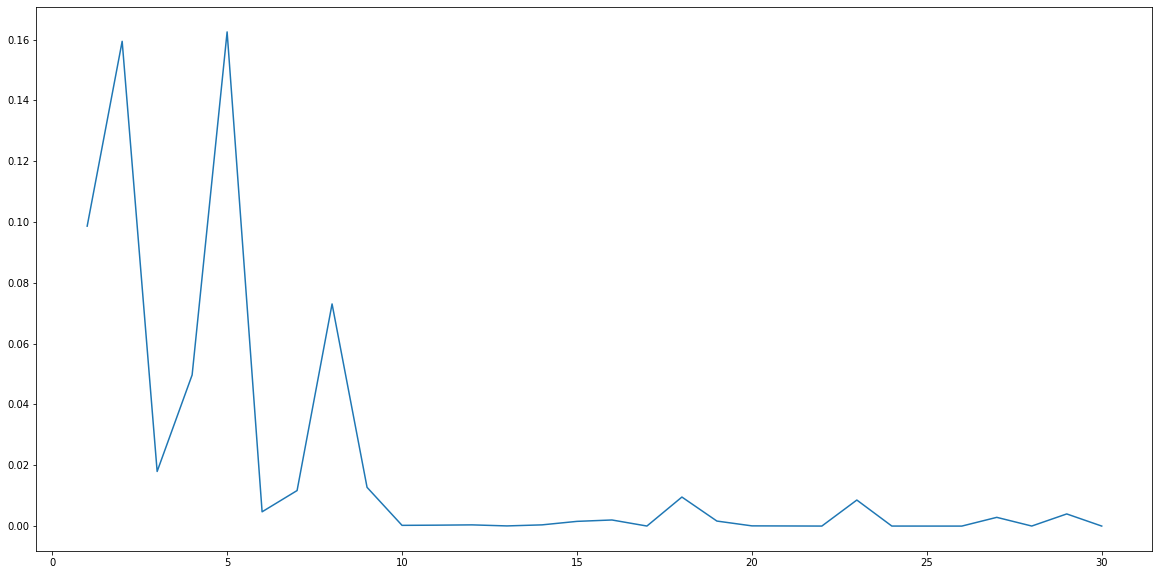

In [7]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

**Data augmentation**

In [36]:
import importlib

importlib.reload(mnist)

Training on device  cpu


<module 'mnist' from '/home/cino/Deep_Learning/MNIST/src/mnist.py'>

In [37]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio,2,torchvision.transforms.RandomAffine(degrees=(-10,10)))

training time: 273.887144 	 train accuracy: 0.996500 	 valid accuracy: 0.992625 


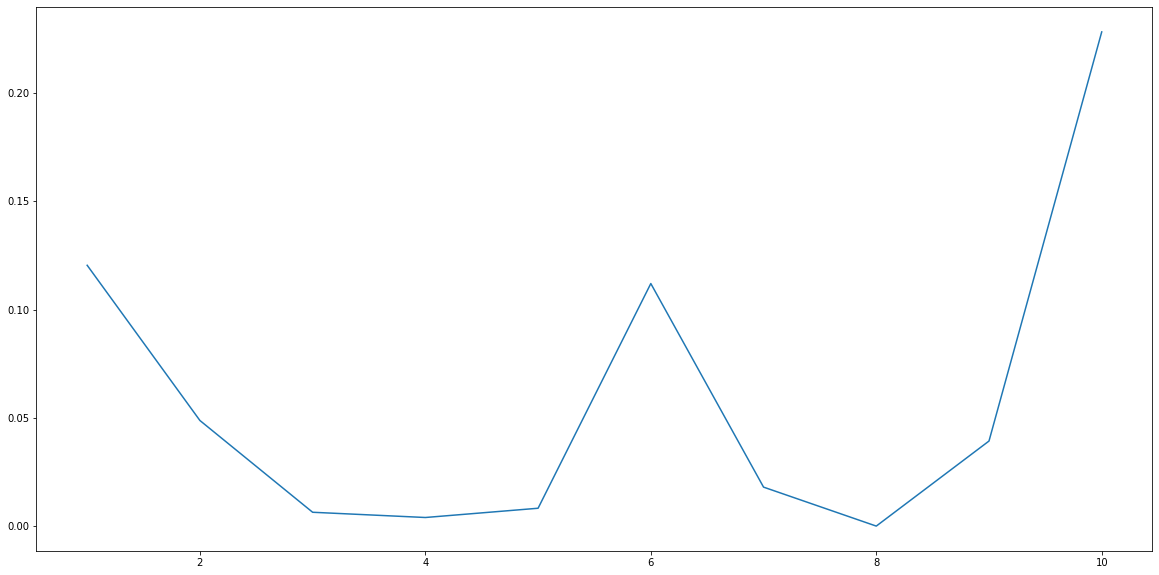

In [10]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.812696 	 train accuracy: 0.996844 	 valid accuracy: 0.994625 


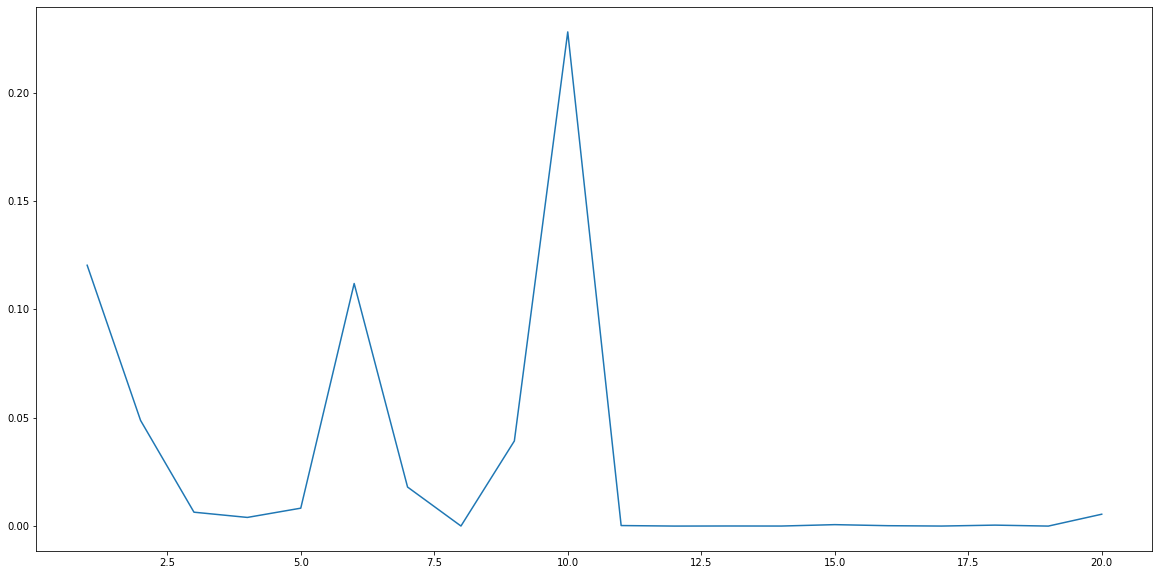

In [11]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 277.206565 	 train accuracy: 0.999156 	 valid accuracy: 0.996875 


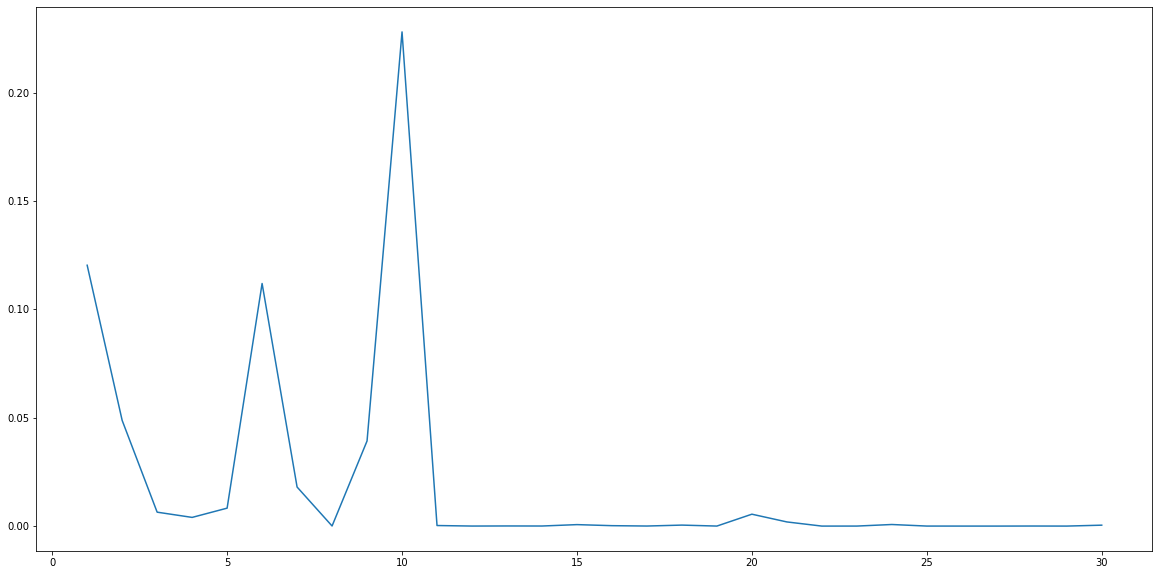

In [12]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.069509 	 train accuracy: 0.999594 	 valid accuracy: 0.997625 


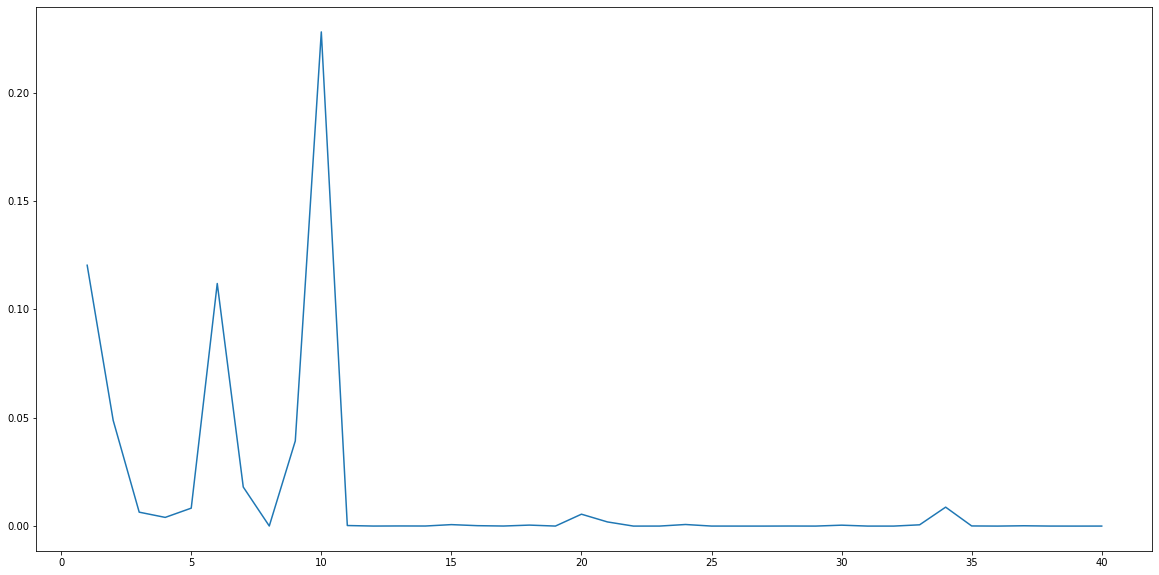

In [13]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 281.177121 	 train accuracy: 0.999875 	 valid accuracy: 0.998125 


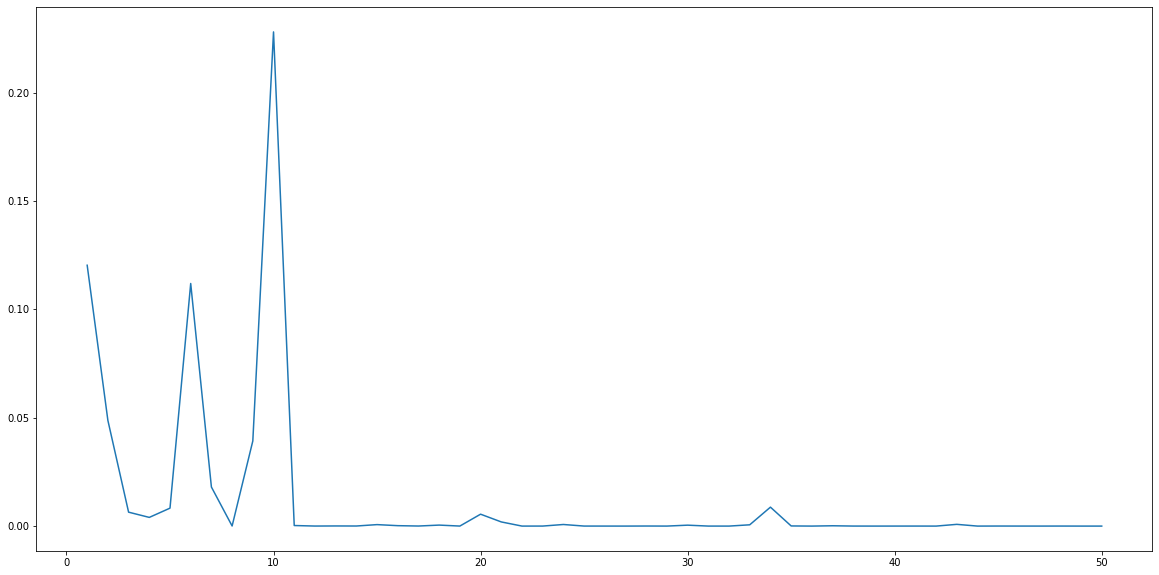

In [14]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.879730 	 train accuracy: 0.999406 	 valid accuracy: 0.997875 


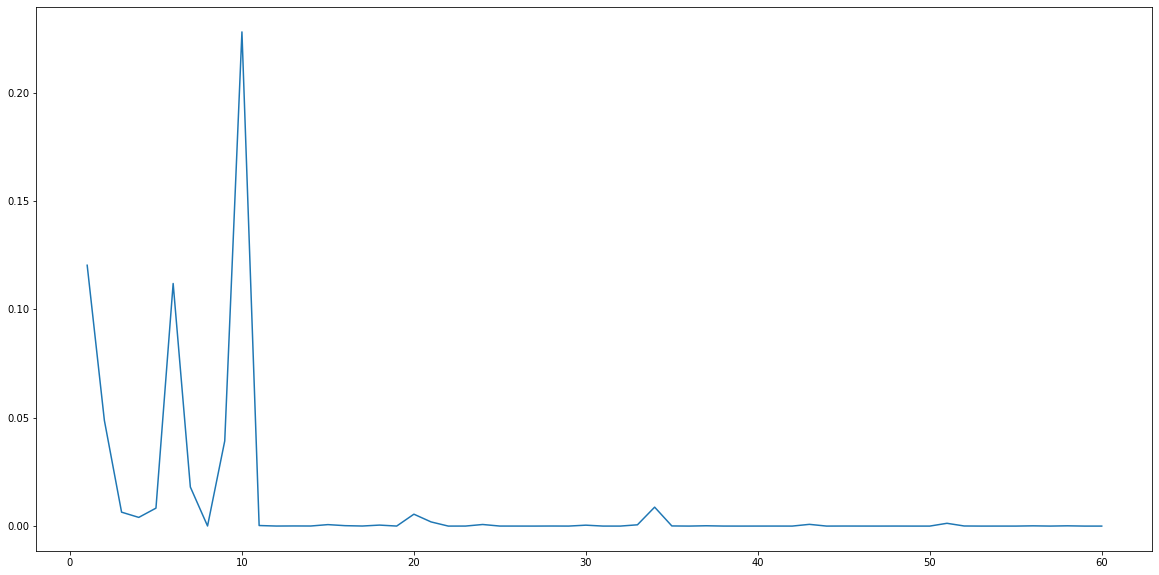

In [15]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 275.762794 	 train accuracy: 1.000000 	 valid accuracy: 0.998500 


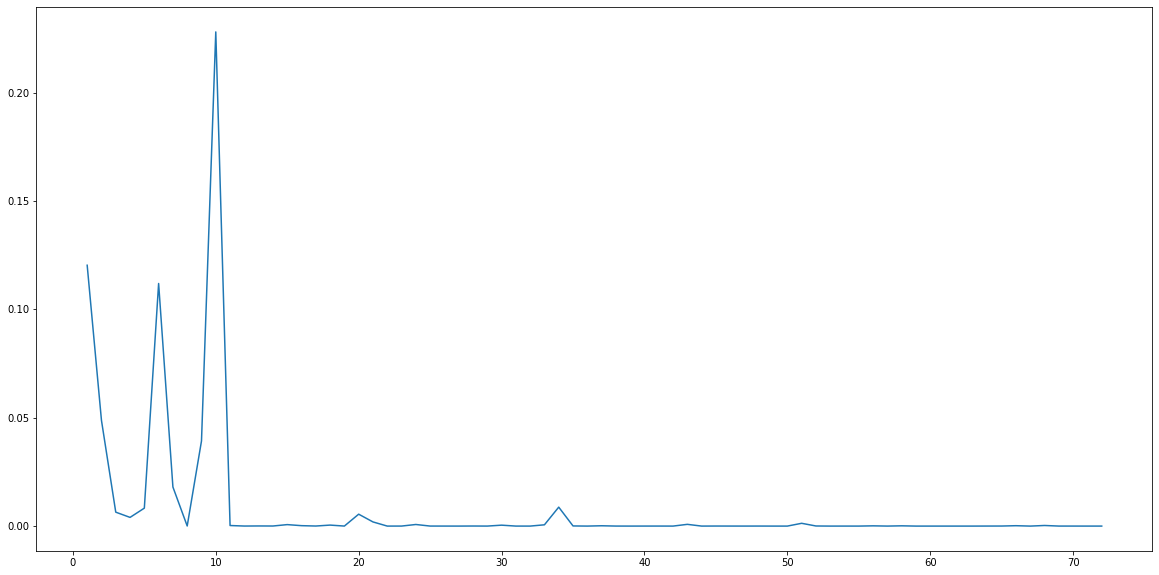

In [17]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
class MNISTdigits2dTest(torch.utils.data.Dataset):
  def __init__(self, file_name):
        'Initialization'
        test_data=pd.read_csv(file_name)
        data_points=test_data.to_numpy()
        self.data_tensor=torch.from_numpy(data_points/255).float()
        self.data_tensor=self.data_tensor.view(-1,1,28,28)
  def __len__(self):
        'Denotes the total number of samples'
        return self.data_tensor.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
       
        X = self.data_tensor[index,:]
        if self.transform:
            X = self.transform(X)

        return index+1, X

In [ ]:
def create_submission_file(model,out_file_name):
    model.eval()
    data_set=MNISTdigits2dTest('../input/digit-recognizer/test.csv')
    data_loader=torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)
    indices=[]
    predictions=[]
    with torch.no_grad():
        for batch_indices,batch_imgs in data_loader:
            batch_imgs=batch_imgs.to(device=available_device)
            batch_indices=batch_indices.to(device=available_device)
            _, batch_predictions = torch.max(model(batch_imgs), dim=1)
            indices.append(batch_indices)
            predictions.append(batch_predictions)
    tensor_indices=torch.cat(tuple(indices),dim=0)
    tensor_predictions=torch.cat(tuple(predictions),dim=0)
    result_data_frame=pd.DataFrame({'ImageId':tensor_indices.cpu().numpy(), 'Label':tensor_predictions.cpu().numpy()})
    result_data_frame.set_index('ImageId')
    result_data_frame.to_csv(out_file_name,index=False)

In [ ]:
create_submission_file(resnet.model,'./submission.csv')